In [1]:
import os
print(os.getcwd())
os.chdir('experimentation_files')



/mnt/c/Users/User/MSc_Project/energy_budget_PET_framework-1


In [2]:
#Libraries
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import sys
import io
import warnings

data_original = pd.read_csv('energy_records.csv',  encoding='utf-8')
data = pd.read_csv('energy_records.csv',  encoding='utf-8')
data = data.drop('dataset_name', axis=1)



In [4]:
def count_outliers_per_record(df, features):
    outlier_counts = []  
    df_2 = df.copy()
    df_2[features] = df_2[features].apply(pd.to_numeric, errors='coerce')
    for index, row in df_2.iterrows():
        outlier_count = 0
        for feature in features:
            Q1 = df_2[feature].quantile(0.25)
            Q3 = df_2[feature].quantile(0.75)
            IQR = Q3 - Q1
            outlier_step = 1.5 * IQR
            
            
            if row[feature] < Q1 - outlier_step or row[feature] > Q3 + outlier_step:
                outlier_count += 1
        
        outlier_counts.append(outlier_count)
    
    return outlier_counts

In [3]:
features = [
    'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
 ]

features_temp = [
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
]
target_ml = 'energy'

In [4]:

def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]

            # Appending 0 if first is greater, otherwise 1
            if first > second:
                result.append(0)
            else:
                result.append(1)
    return result

def our_ml(dataset, test_size, our_features, estimators, learning_rate, depth,  scalee, p = 0):
    
    
  
    

    split_index = int((1 - test_size) * len(data))
    X = dataset[list(our_features)]
    y = dataset['energy']
    if scalee == 1:
            continuous_ones = [i for i in our_features if i != 'epsilon']

            X_scaled = X.copy()
            X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])

         
            X_train = X_scaled.iloc[:split_index]
            X_test = X_scaled.iloc[split_index:]
            
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]



    
    gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    if p == 0:
        print('Conditions:')
        print(f'Size: {len(dataset)}')
        print(f'Test size percent is: {test_size}')
        print(f'Attributes: {our_features}')
 
        

        print("Gradient Boosting MSE:", mse)
        print("Gradient Boosting R²:", r2)

    feature_importances = gb_model.feature_importances_

    importances = pd.Series(feature_importances, index=our_features)
    
    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        
        
        
        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
        if p ==0:
            print(aa)
            print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {acc} %')
            
            print('Prediction vs Actual')
        y_test_2 = list(y_test)
        
    else:
        print('Fix the test size for even number of values.')
        y_pred = 0
        y_test_2 = 0
        acc = 0


  
    return gb_model, y_pred, y_test_2, importances,  mse, r2, acc


def lightgbm_ml(our_data, our_features, target, perc, scalee, n_estimators=100, learning_rate=0.1, depth=-1 ):
    warnings.simplefilter(action='ignore', category=UserWarning)
    test_size = perc
    split_index = int((1 - test_size) * len(our_data))
    X = our_data[list(our_features)]
    y = our_data[target]

    if scalee == 1:
        continuous_ones = [i for i in our_features if i != 'epsilon']
        X_scaled = X.copy()
        X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])
        X_train = X_scaled.iloc[:split_index]
        X_test = X_scaled.iloc[split_index:]
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]

    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1)
   
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)  
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
        aa = []
        y_test_2 = y_test.reset_index(drop=True)
        y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
        res_act = comp_func(y_test_2)
        res_pred = comp_func(y_pred_2)
        
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
    else:
        aa = []
        acc = 0

    print('\n')
    print(f'Conditions for {target}:')
    print("LightGBM Regression")
    if scalee == 1:
        print("With Scaler")
    print(f'Number of Estimators: {n_estimators}')
    print(f'Learning Rate: {learning_rate}')
    print(f"Best MSE: {mse:.10f}")
    print(f"Best R²: {r2:.10f}")
    print(f'Test size: {perc}')
    print(f"Best Feature Combination: {our_features}")
    print(f'Accuracy: {acc}%')
    
    print("Feature Importances:")
    single_importances_series = pd.Series(model.feature_importances_ , index=our_features)
    importances_percentages = (single_importances_series / single_importances_series.sum())
    print(importances_percentages)
   
    return model, y_pred.tolist(), y_test.tolist(), importances_percentages







In [7]:
import heapq
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import pandas as pd
from itertools import combinations

def bfs_feature_selection(data, features, target, test_size,  models = 0, n_estimators=50, learning_rate=0.1, depth=-1, max_depth_tree=10, max_features='sqrt', max_samples=0.8):
    best_mse = float('inf')
    best_r2 = -1
    best_features = None
    best_model = None
    visited = set()
    evaluation_count = 0

    priority_queue = []

    
    initial_features = ['epsilon']
    heapq.heappush(priority_queue, (float('-inf'), initial_features))

    total_features = len(features)
    total_combinations = 2**total_features - 1

    if models ==0:
        print('LightGBM Regressor')
    elif models ==1:
        print('HitsGB Regressor')
    else:
        print('Regular GB Regressor')

    print("Starting BFS feature selection...")

    while priority_queue:
        current_r2, current_features = heapq.heappop(priority_queue)

        current_features_tuple = tuple(sorted(current_features))
        if current_features_tuple in visited:
            continue

        visited.add(current_features_tuple)

        X = data[current_features]
        y = data[target]

        if X.empty or y.empty:
            print(f"Skipping empty data slice for features: {current_features}")
            continue

        split_index = int((1 - test_size) * len(data))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        if X_train.empty or y_train.empty:
            print(f"Skipping empty training data for features: {current_features}")
            continue

        if models == 0:
            model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1, max_depth = depth,   n_jobs=2)
        elif models == 1:
            if depth <=-0:
                depth = 1
            model = HistGradientBoostingRegressor(max_iter=n_estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)

        else:
            if depth <=-0:
                depth = 3
            model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=depth, random_state=42
                                         # ,  n_jobs=2
                                             )
        try:
            model.fit(X_train, y_train)
        except ValueError as e:
            print(f"Error fitting model with features: {current_features}, Error: {e}")
            continue

        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
            aa = []
            y_test_2 = y_test.reset_index(drop=True)
            y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
            res_act = comp_func(y_test_2)  
            res_pred = comp_func(y_pred_2)
            for i in range(len(res_act)):
                aa.append(res_act[i] == res_pred[i])

            acc = (aa.count(True) / len(aa)) * 100
        else:
            acc = 0

        evaluation_count += 1

        if r2 > best_r2:
            best_r2 = r2
            best_mse = mse
            best_features = current_features
            best_acc = acc
            best_model = model
            print(f"\nNew best R²: {best_r2:.10f}, MSE: {best_mse:.10f}, Compare Accuracy: {best_acc:.2f}% with features: {best_features}")
        elif r2 > 0.91 and r2 > (best_r2 - 0.01) and acc > best_acc:
            
            print(f"\nBetter accuracy with R²: {r2:.10f}, MSE: {mse:.10f}, Compare Accuracy: {acc:.2f}% with features: {current_features}")

        if evaluation_count % 200 == 0:
            print(f"\rEvaluated {evaluation_count} combinations out of {total_combinations}", end='', flush=True)

        
        for feature in features:
            if feature not in current_features:
                new_features = current_features + [feature]
                heapq.heappush(priority_queue, (-r2, new_features))

    print("\nBFS complete.")
    print(f"Best feature combination: {best_features}")
    print(f'Learning Rate { learning_rate}')
    print(f'Estimators { n_estimators}')
    print(f"Best R²: {best_r2:.10f}")
    print(f"Best MSE: {best_mse:.10f}")
    print(f"Best Compare Accuracy: {best_acc:.2f}%")
    print('\n\n----------------------------------------------------------------------------------------\n\n')

    return best_model, best_features, best_mse, best_r2


In [8]:
bfs_feature_selection(data, features, target_ml,  0.19,  models = 2, n_estimators=100, learning_rate=0.1, depth=3, max_depth_tree=10, max_features='sqrt', max_samples=0.8)

""""
Regular GBR
AFTER 4 minutes, it tried 1600 combinations and provided the following best results:
Better accuracy with R²: 0.9308170302, MSE: 713311.3535881062, Compare Accuracy: 80.65% with features: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'mean_categorical_unique', 'kurtosis', 'max_continuous_correlation', 'mean_continuous_correlation', 'num_records', 'min_categorical_unique', 'num_categorical_attributes', 'entropy', 'skewness']


"""

Regular GB Regressor
Starting BFS feature selection...

New best R²: -0.0551216195, MSE: 10878836.6933777612, Compare Accuracy: 41.94% with features: ['epsilon', 'num_attributes']

New best R²: 0.5204340234, MSE: 4944567.3815242453, Compare Accuracy: 38.71% with features: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio']

New best R²: 0.5455172360, MSE: 4685946.7933718050, Compare Accuracy: 41.94% with features: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio']

New best R²: 0.6761835913, MSE: 3338710.6885309229, Compare Accuracy: 41.94% with features: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'mean_categorical_unique']

New best R²: 0.7079238721, MSE: 3011452.3661501599, Compare Accuracy: 77.42% with features: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'mean_categorical_unique', 'kurtosis']

New best R²: 0.7426987332, MSE: 2652905.9885163950, Compare Accuracy: 77.42% with features: 

KeyboardInterrupt: 

In [5]:
best_features_1 = ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 
                   'mean_categorical_unique', 'kurtosis', 'max_continuous_correlation', 'mean_continuous_correlation',
                     'num_records', 'min_categorical_unique', 'num_categorical_attributes', 'entropy', 'skewness']
first_1, first_predictions, first_actual, first_importances, first_mse, first_r2, first_acc  = our_ml(data, 0.19, best_features_1, 100, 0.1, 3, 0)

Conditions:
Size: 324
Test size percent is: 0.19
Attributes: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'mean_categorical_unique', 'kurtosis', 'max_continuous_correlation', 'mean_continuous_correlation', 'num_records', 'min_categorical_unique', 'num_categorical_attributes', 'entropy', 'skewness']
Gradient Boosting MSE: 713387.8393546941
Gradient Boosting R²: 0.9308096119478035
[True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, True, False, True, True, True]
Accuracy of the comparison which one more consumable/accurate/riskier: 80.64516129032258 %
Prediction vs Actual


Conditions:
Size: 324
Test size percent is: 0.19
Attributes: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'mean_categorical_unique', 'kurtosis', 'max_continuous_correlation', 'mean_continuous_correlation', 'num_records', 'min_categorical_unique', 'num_categorical_attributes', 'entropy', 'skewness']
Gradient Boosting MSE: 713387.8393546941
Gradient Boosting R²: 0.9308096119478035
[True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, True, False, True, True, True]
Accuracy of the comparison which one more consumable/accurate/riskier: 80.64516129032258 %
Prediction vs Actual
<class 'pandas.core.series.Series'>

Importances Sorted
num_attributes                 0.795199
num_records                    0.098141
mean_categorical_unique        0.025083
entropy                        0.018526
mean_continuous_correlation    0.017896
imbalance_ratio          

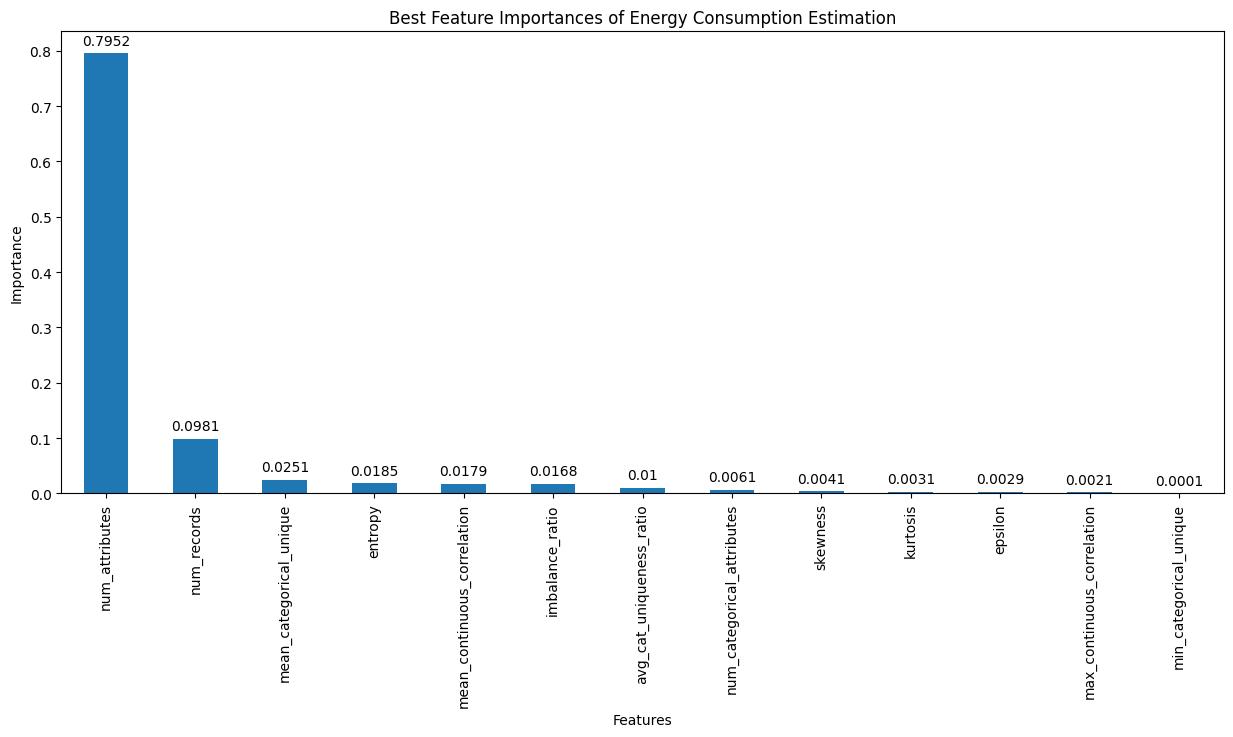

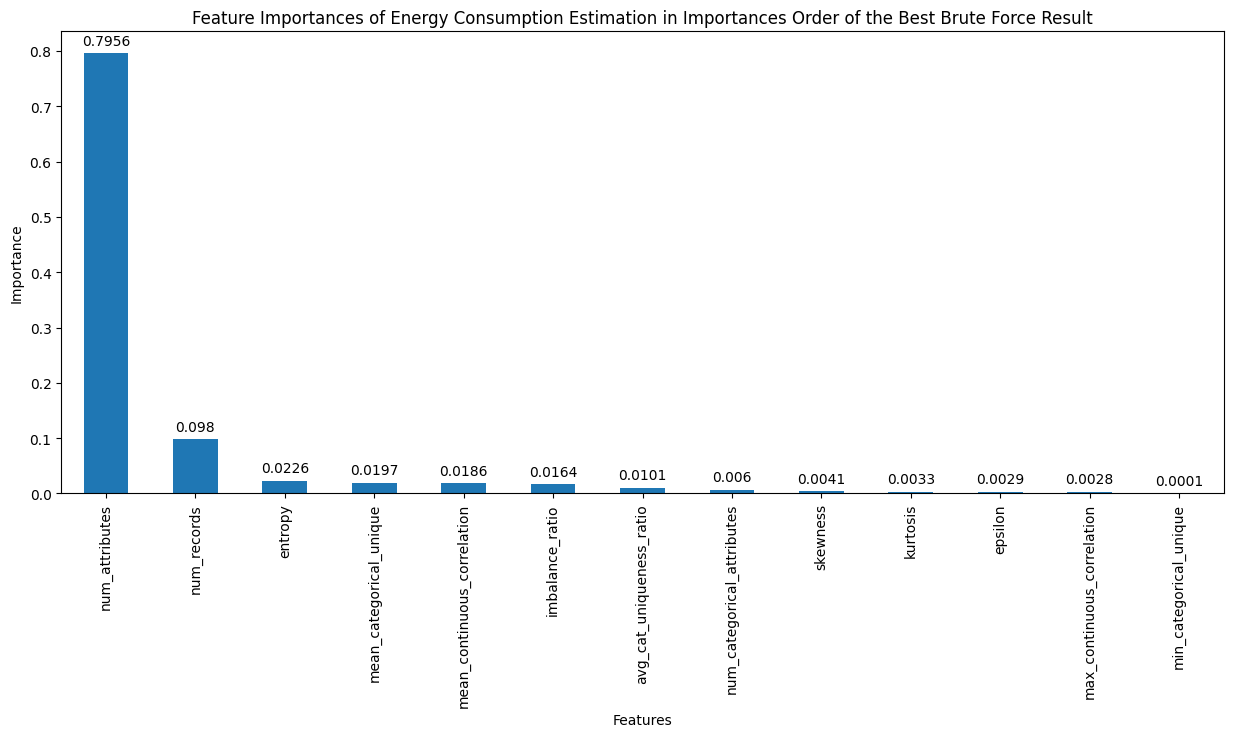

'"  \n\nAttributes: [\'epsilon\', \'num_attributes\', \'avg_cat_uniqueness_ratio\', \'imbalance_ratio\', \'mean_categorical_unique\', \'kurtosis\', \'max_continuous_correlation\', \'mean_continuous_correlation\', \'num_records\', \'min_categorical_unique\', \'num_categorical_attributes\', \'entropy\', \'skewness\']\nGradient Boosting MSE: 713387.8393546941\nGradient Boosting R²: 0.9308096119478035\n[True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, True, False, True, True, True]\nAccuracy of the comparison which one more consumable/accurate/riskier: 80.64516129032258 %\n\n\nAfter switching order:\nAttributes: [\'num_attributes\', \'num_records\', \'mean_categorical_unique\', \'entropy\', \'mean_continuous_correlation\', \'imbalance_ratio\', \'avg_cat_uniqueness_ratio\', \'num_categorical_attributes\', \'skewness\', \'kurtosis\', \'epsilon\', \'max_continuous_correlation\', \'m

In [ ]:
"""
THIS DEMONSTRATES THAT THE ORDER OF FEATURES IMPACTS THE RESULTS.

"""

print(type(first_importances))
first_importances_sorted = first_importances.sort_values(ascending=False)

fffff = first_importances_sorted.index.tolist()
print('\nImportances Sorted')


print(first_importances_sorted)
print(fffff)

print('Features with one of the best R2 scores: 0.9499310444235638 ')
print(best_features_1)
print('\n')

ee0, ee1, ee2, ee3_importances, ee4, ee5, ee6  = our_ml(data, 0.19, fffff, 100, 0.1, 3, 0)
print('\n')

plt.figure(figsize=(15, 6))
ax = first_importances_sorted.plot(kind='bar')
for i, v in enumerate(first_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
plt.title('Best Feature Importances of Energy Consumption Estimation')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()


ee3_importances_sorted = ee3_importances.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
ax = ee3_importances_sorted.plot(kind='bar')
for i, v in enumerate(ee3_importances_sorted.values):
    rounded_value = round(v, 4)
    ax.text(i, v + 0.01, f'{rounded_value}', ha='center', va='bottom')
plt.title('Feature Importances of Energy Consumption Estimation in Importances Order of the Best Brute Force Result')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()
""""  

Attributes: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'imbalance_ratio', 'mean_categorical_unique', 'kurtosis', 'max_continuous_correlation', 'mean_continuous_correlation', 'num_records', 'min_categorical_unique', 'num_categorical_attributes', 'entropy', 'skewness']
Gradient Boosting MSE: 713387.8393546941
Gradient Boosting R²: 0.9308096119478035
[True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, True, False, True, True, True]
Accuracy of the comparison which one more consumable/accurate/riskier: 80.64516129032258 %


After switching order:
Attributes: ['num_attributes', 'num_records', 'mean_categorical_unique', 'entropy', 'mean_continuous_correlation', 'imbalance_ratio', 'avg_cat_uniqueness_ratio', 'num_categorical_attributes', 'skewness', 'kurtosis', 'epsilon', 'max_continuous_correlation', 'min_categorical_unique']
Gradient Boosting MSE: 747935.5754401103
Gradient Boosting R²: 0.9274588802220748
[True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, True, False, True, True, True]
Accuracy of the comparison which one more consumable/accurate/riskier: 80.64516129032258 %


"""

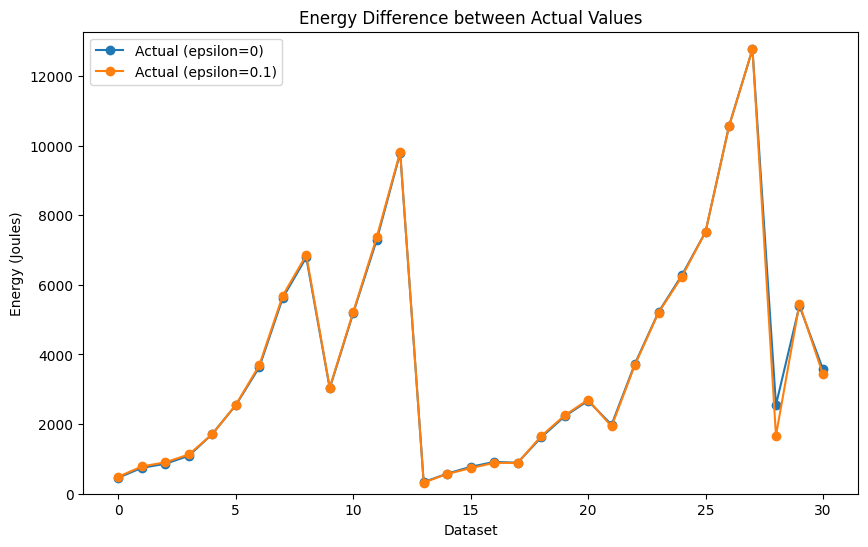

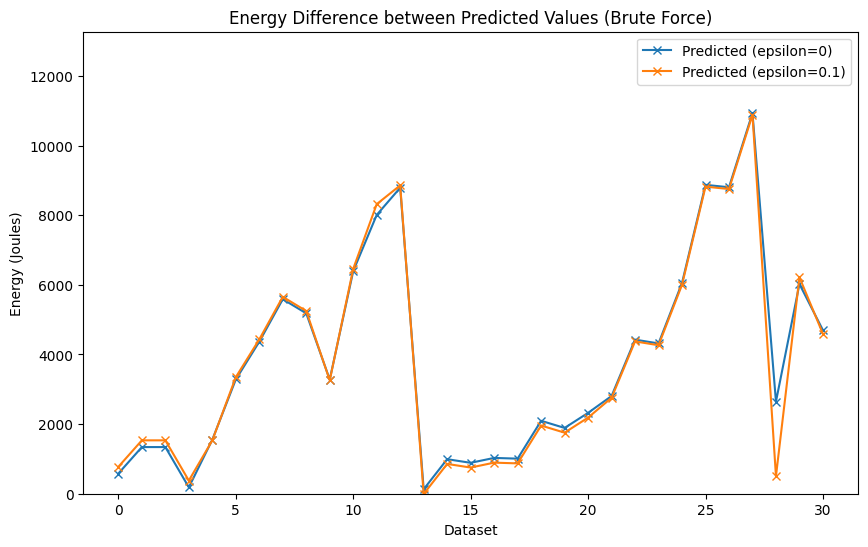

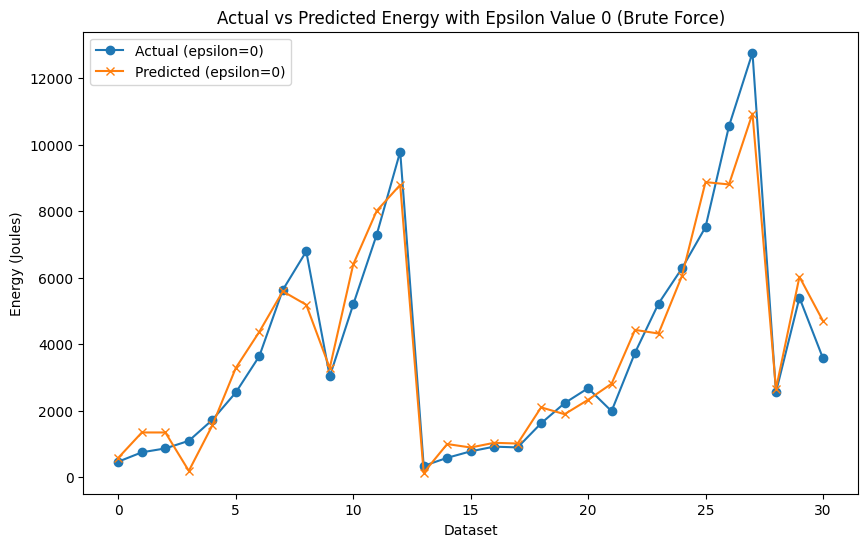

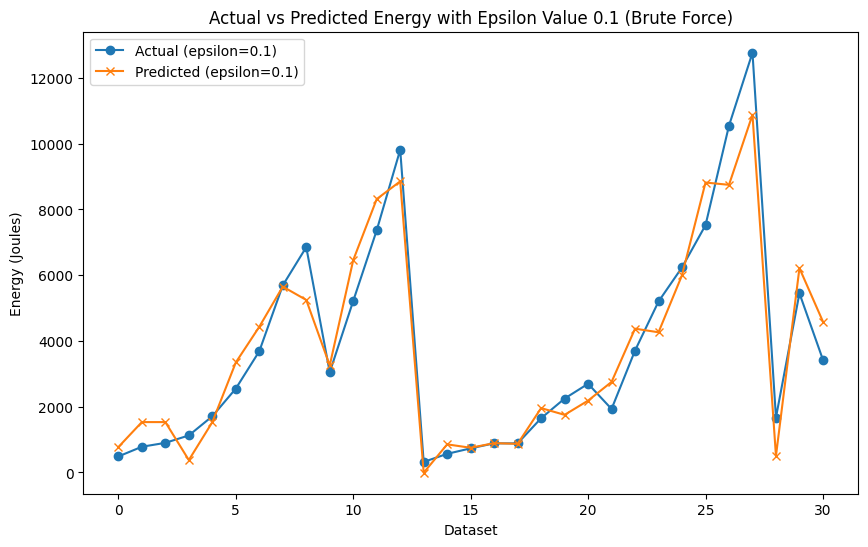

In [7]:
best_actual_0 = [first_actual[i] for i in range(0, len(first_actual), 2)]   # Actual values for epsilon 0
best_actual_01 = [first_actual[i] for i in range(1, len(first_actual), 2)]  # Actual values for epsilon 0.1
y_pred_0 = [first_predictions[i] for i in range(0, len(first_predictions), 2)]  # Predicted values for epsilon 0
y_pred_01 = [first_predictions[i] for i in range(1, len(first_predictions), 2)] # Predicted values for epsilon 0.1

x_indices_0 = range(len(best_actual_0))     # Indices for epsilon 0
x_indices_01 = range(len(best_actual_01))   # Indices for epsilon 0.1
y_min = 0
y_max = max(max(best_actual_0), max(best_actual_01), max(y_pred_0), max(y_pred_01)) + 500

# Plot 1: Difference between actual values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.ylim(y_min, y_max)
plt.title('Energy Difference between Actual Values')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
# plt.savefig('energy_brute_difference_between_actual_values.png') 
plt.show()

# Plot 2: Difference between predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Energy Difference between Predicted Values (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
plt.savefig('energy_brute_difference_between_predicted_values.png')  

# Plot 3: Actual vs Predicted for epsilon 0
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.title('Actual vs Predicted Energy with Epsilon Value 0 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
plt.savefig('energy_brute_actual_vs_predicted_epsilon_0.png')  
plt.show()

# Plot 4: Actual vs Predicted for epsilon 0.1
plt.figure(figsize=(10, 6))
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.title('Actual vs Predicted Energy with Epsilon Value 0.1 (Brute Force)')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
plt.savefig('energy_brute_actual_vs_predicted_epsilon_01.png')  
plt.show()


# Ignore Contents Below

In [ ]:
sec_1, sec_predictions, sec_actual, sec_importances, sec_mse, sec_r2, sec_acc  = our_ml(data, 0.19, features, 100, 0.1, 3, 0)
importances_sorted_1 = sec_importances.sort_values(ascending=False)
# pd.options.display.float_format = '{:.4f}'.format

importances_sorted_1 = importances_sorted_1.round(5)
print(importances_sorted_1)



importances_sorted_no_epsilon = importances_sorted_1.drop('epsilon')
print(importances_sorted_no_epsilon)
print('\n hohoh')
important_features = importances_sorted_no_epsilon[:16].index.tolist()
# importance > 0.0018
print(important_features)


plt.figure(figsize=(15, 6))
ax = importances_sorted_1.plot(kind='bar')
for i, v in enumerate(importances_sorted_1.values):
    ax.text(i, v + 0.01, f'{v}', ha='center', va='bottom')
plt.title('Feature Importances of Energy Consumption of Synthetic Data Generation Estimation')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()

In [ ]:
def move_epsilon_first(sorted_features):
    """
    This function takes a list of sorted features and ensures 'epsilon' is always the first feature.
    
    sorted_features (list): List of features sorted by their importance.
    """
    # Check if 'epsilon' is in the list and remove it if present
    if 'epsilon' in sorted_features:
        sorted_features.remove('epsilon')
        # Insert 'epsilon' at the first position
        sorted_features.insert(0, 'epsilon')
    return sorted_features


In [ ]:
from itertools import permutations
import pandas as pd
import math
import random
import numpy as np

def evaluate_sampled_orders_with_importances(data, feature_list, target, estimators, learning_rate, depth, test_size=0.19, scalee=0, max_orders=10000, n_features_to_use=None, random_seed=None):
    """
    Tries all possible orders of the given feature list and returns the best R², MSE, and comparison accuracy.
    Records the best R² score corresponding to the best comparison accuracy or better. Calculates and returns
    the mean feature importances across all permutations evaluated.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing features and target variable.
    - feature_list (list): List of feature names to use in the model.
    - target (str): Name of the target variable in the dataset.
    - estimators (int): Number of estimators (trees) for the gradient boosting model.
    - learning_rate (float): Learning rate for the gradient boosting model.
    - depth (int): Maximum depth of the trees.
    - test_size (float): Proportion of the dataset to include in the test split.
    - scalee (int): Indicates whether to scale the data (1 to scale, 0 otherwise).
    - max_orders (int): Maximum number of permutations to evaluate (default is 1000).
    - n_features_to_use (int): Number of features to randomly select from the feature list for each evaluation.
    - random_seed (int): Seed for random number generator for reproducibility.
    
    Returns:
    - best_results (dict): Dictionary containing best R², MSE, and comparison accuracy, along with the best feature order.
    - mean_importances_df (pd.DataFrame): DataFrame containing features and their average importance.
    """
    # Save the current random states
    random_state = random.getstate()
    np_random_state = np.random.get_state()
    
    # Store and print the current state before setting the new seed
    current_random_seed = random.getstate()
    print(f"Current random state before setting seed: {current_random_seed}")
    
    if random_seed is not None:
        print(f"Using random seed: {random_seed}")
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    try:
        best_r2 = -float('inf')
        best_mse = float('inf')
        best_acc = -float('inf')
        best_best_acc = -float('inf')
        best_r2_for_best_acc = -float('inf')
        best_order_r2 = None
        best_order_acc = None

        best_results = {
            'best_r2': None, 
            'best_mse': None, 
            'best_acc': None, 
            'best_order_r2': None, 
            'best_order_acc': None,
            'best_r2_for_best_acc': None
        }

        all_importances = {feature: [] for feature in feature_list}

        # Ensure 'epsilon' is in the feature list
        if 'epsilon' not in feature_list:
            raise ValueError("'epsilon' must be included in the feature list.")

        # Create a copy of the feature list without 'epsilon'
        feature_list_copy = [feature for feature in feature_list if feature != 'epsilon']
        epsilon = ['epsilon']  # Define 'epsilon' separately

        # Determine the number of features to use in each random sample
        # n_features_to_use = n_features_to_use or len(feature_list_copy)

        # Adjust max_orders if needed
        # max_orders = min(max_orders, math.comb(len(feature_list_copy), n_features_to_use))

        # Generate random samples of the feature list with the specified number of features
        sampled_orders = set()
        while len(sampled_orders) < max_orders:
            random_features = random.sample(feature_list_copy, n_features_to_use)
            random_order = tuple(epsilon + random_features)
            sampled_orders.add(random_order)

        total_orders = len(sampled_orders)

        # Initialize a counter for progress tracking
        completed_orders = 0

        for order in sampled_orders:
            # Run the model with the current feature order
            model, y_pred, y_test, importances, mse, r2, acc = our_ml(data, test_size, order, estimators, learning_rate, depth, scalee, p=1)

            # Store feature importances
            for feature, importance in zip(order, importances):
                all_importances[feature].append(importance)

            # Check for the best R²
            if r2 > best_r2:
                best_r2 = r2
                best_mse = mse
                best_order_r2 = order
                best_acc = acc
                best_results['best_r2'] = r2
                best_results['best_mse'] = mse
                best_results['best_acc'] = acc
                best_results['best_order_r2'] = order
                best_results['best_importances'] = importances
                print(f"\nCurrent Best: R²: {r2}, MSE: {mse}, Comparison Accuracy: {acc}, Features: {order}")

            # Check for the best comparison accuracy and update if necessary
            if acc > best_acc and  r2 > 0.94 and r2 > (best_r2_for_best_acc - 0.1):

                best_best_acc = acc
                best_order_acc = order
                best_r2_for_best_acc = r2
                best_results['best_best_acc'] = acc
                best_results['best_order_acc'] = order
                best_results['best_r2_for_best_acc'] = r2
                best_results['best_importances_best_acc'] = importances
                print(f"\nCurrent Best Best Acc: Comparison Accuracy: {acc}, Features: {order},  R²: {r2}")

            # Update if R² is better while accuracy is equal to best accuracy
            # elif acc >= best_best_acc and r2 > (best_r2_for_best_acc - 0.1) and r2 > 0.9:
            #     best_best_acc = acc
            #     best_r2_for_best_acc = r2
            #     best_order_acc = order
            #     best_results['best_acc'] = acc
            #     best_results['best_order_acc'] = order
            #     best_results['best_r2_for_best_acc'] = r2

            completed_orders += 1
            if completed_orders % 200 == 0:
            # Print progress on the same line without cluttering the output
                print(f"\rProgress: {completed_orders}/{total_orders} orders completed. {completed_orders/total_orders:.2%} complete", end='\r',  flush=True)

        # Calculate mean importance for each feature
        mean_importances = {feature: np.mean(importances) for feature, importances in all_importances.items() if importances}
        mean_importances_df = pd.DataFrame(mean_importances.items(), columns=['Feature', 'Mean Importance']).sort_values(by='Mean Importance', ascending=False)

        # Print out the best results
        print('\n\nConditions')
        print(f"Learning rate: { learning_rate}, Estimators:  {estimators}")
        if random_seed is not None:
            print(f"Using random seed: {random_seed}")
    
        print("Best R² Score:")
        print(f"R²: {best_r2}, MSE: {best_mse}, Comparison Accuracy { best_acc}, Features: {best_order_r2}")
        print("Best Comparison Accuracy:")
        print(f"Accuracy: {best_best_acc}%, R²: {best_r2_for_best_acc}, Features: {best_order_acc}\n\n")

    finally:
        # Restore the original random states
        random.setstate(random_state)
        np.random.set_state(np_random_state)
        print(f"\nRandom state restored to original state: {random_state}")

    return best_results, mean_importances_df



In [ ]:
#Original Seed
# (3, (847202648, 1687714253, 1756603946, 1849564526, 3522555017, 181218929, 4138812367, 4131576807, 4264243016, 2153514938, 2879918170, 986971026, 3864962659, 4015835248, 3845989067, 539129954, 3523143872, 1711163242, 2825640796, 55185138, 2890837647, 1243175842, 1759817646, 3500783805, 345396859, 961183814, 1222379627, 2019707732, 140872230, 2518426828, 1087742071, 4268586653, 392714211, 3965581128, 4131076328, 486635923, 3701844050, 3604011314, 3530700254, 1457091257, 1087750363, 2612782897, 3708312541, 3583850993, 1288742224, 3463677930, 2584095043, 3769905179, 406497780, 2742474753, 2793882692, 274322452, 2760621904, 3472884645, 3802690154, 1060102109, 4213923071, 3867234121, 3205483157, 1298795988, 2136124086, 2570559701, 3506877508, 3099090941, 146655892, 3356955406, 1109802585, 3038861925, 2973696739, 2064304079, 1850095695, 2346528295, 672785861, 128806958, 209154998, 1248042940, 886250999, 2806699539, 4062245367, 597599818, 3920715081, 271158731, 2809733915, 590162835, 1810442161, 3165259709, 1892650376, 1047977548, 3421198244, 2901958460, 3377309663, 2847950595, 2996908619, 4148644261, 2779994007, 1538626138, 3279263822, 1061611883, 966700706, 287981580, 4022532450, 1561234723, 2536075993, 3325455317, 1623416844, 4237266236, 560328397, 3239379344, 2442767461, 750200859, 3623349739, 3222382258, 403418116, 2302873024, 1137006915, 598736373, 2826137813, 1015787486, 3018617256, 764031016, 3041642139, 1842853833, 898079915, 1713508090, 3553308514, 3962074088, 684917188, 3902900335, 1992727343, 2454307301, 1297030688, 3437520530, 225972147, 1919172072, 2117540888, 1862219076, 3587209562, 2032115405, 2082159823, 3617661351, 4105243634, 1627654765, 3817863329, 1769399736, 3774644335, 3345798761, 128298387, 812539996, 2853742922, 3649154579, 166796400, 371439790, 2583221158, 2376768584, 840377951, 2463115110, 1326972283, 450007099, 2892895307, 1104823931, 268470056, 338154030, 4248311133, 4286619909, 2942946836, 2825311484, 2032892028, 1517507238, 1697523376, 1357534720, 309609513, 305060017, 35773665, 1893156065, 1206607149, 4237602440, 1652538831, 444755760, 1816339278, 675102433, 2453152895, 885709268, 3869277078, 2768343215, 1021574190, 1167951622, 3082733928, 1437949704, 3288654763, 1220118288, 2777067311, 2508408859, 2622761176, 3455949857, 14622412, 3725857793, 138640487, 4076040481, 2247636455, 466193970, 824099217, 159081920, 1766028929, 3677371517, 3950739851, 2731931663, 1492660869, 2149122587, 1076128462, 3144658490, 356993710, 3337580187, 3784513368, 1011472876, 3187868754, 2996791401, 2941698393, 191468483, 1761130758, 3108213616, 2749633319, 1070007869, 1687682483, 1340487608, 23438420, 327048644, 2651615043, 1857774701, 3443285052, 2581114905, 2203979750, 3687023464, 2973314777, 585632069, 1272728676, 3662452976, 3918529730, 2853023416, 437209586, 4000869982, 3163706554, 1644684789, 2821145462, 1355418839, 111259842, 3865600480, 918679663, 1697160230, 1560173788, 2552152832, 646611922, 3950553136, 3859003050, 2685666695, 600759240, 1428059789, 4082751295, 2802871323, 1536758962, 3411757793, 2924409777, 1907485374, 837251534, 1064341656, 4215826222, 3276963774, 3442719355, 175015696, 2474029697, 1350125171, 3678808090, 4279944653, 4200079660, 605656537, 1240707577, 2533182544, 4133977389, 2306866010, 546875644, 3760819023, 1012720547, 3591432623, 2943280007, 1742458586, 2631919043, 3915157768, 2508420198, 368213003, 2521140682, 3320916907, 684911253, 1125198163, 516682055, 2217098076, 1869003746, 846259337, 27597203, 2751188488, 2420252362, 286256702, 3243846078, 2050185499, 2968993502, 3675562075, 430575496, 3769996076, 3992900979, 4103893834, 2696347868, 806545677, 1862646120, 1475606396, 1358584183, 3951941298, 3635020, 544004202, 2857287454, 309558194, 1336356798, 3149817140, 1454790008, 2780183386, 982070408, 4961358, 792297418, 1036316221, 2006281621, 4150956309, 733610583, 3914221569, 3357164399, 3419582757, 4155541384, 197633573, 2915737811, 1066428379, 1370823111, 2550490523, 1663020656, 2195206724, 130641072, 3806710256, 3644983181, 812453401, 3132053116, 4188359042, 3429689382, 3269818294, 2752072888, 2568819316, 2653255049, 3058031874, 3619377229, 1260397382, 2238154078, 1909062835, 3597038762, 1660386797, 2432860925, 1748708617, 1571791956, 3023844691, 2264103083, 721259450, 90509050, 1023340261, 3604237047, 2703137345, 312013222, 2002801693, 3998304352, 1863807983, 3168223427, 1939603378, 2412744007, 2587518126, 37546314, 2336661348, 4078703905, 2167406191, 2984578748, 3850163645, 3596829020, 1679933916, 1759872942, 9611969, 3244149365, 2750155443, 8908386, 2221053655, 3597931105, 4071687592, 1031086944, 516348045, 1240102713, 2096167499, 302751290, 2683942177, 3480832506, 2234258910, 4108493546, 605129125, 2882109573, 2366276744, 256885467, 559176057, 1429952273, 3805087838, 1015307657, 3807010386, 3553484056, 1051126031, 854211175, 3362201783, 2945075607, 615987262, 730653288, 2853410752, 3634525429, 3499101491, 2075773241, 3451867173, 1864725784, 1320080963, 603103166, 1126924901, 3964341772, 2876673027, 3924208696, 1998123557, 3141851792, 3892542351, 3285833583, 927787821, 815392459, 2152740486, 4020015576, 683158508, 3575173056, 3755439905, 3822687286, 318269726, 3534864936, 121004585, 1857039532, 2214290936, 2346249091, 1574665829, 2251440685, 943623399, 3914110618, 509524191, 243860327, 2499000128, 1323775387, 4012986027, 1583613758, 1155769655, 2541125050, 4243191121, 2732872480, 2631843578, 3582663469, 2440086770, 2558990107, 328660566, 1069348649, 2907155427, 1829954377, 3924998772, 387978471, 4182254454, 1926593207, 1229865668, 3863302355, 3106741690, 1415217362, 1008162110, 113512014, 1224736789, 1557851182, 1381818893, 739397512, 439349756, 2677930348, 2213301554, 717037395, 2773252539, 2156861829, 1698747086, 3104425543, 4047190905, 1256099554, 3940642045, 3489540636, 851446387, 989234160, 4238101383, 586266811, 567779495, 1640566691, 3958307919, 3266130197, 1782083544, 573816822, 3131756973, 658301883, 3705101000, 3062712630, 658756054, 1467534389, 3019229650, 4041946851, 2140889300, 2287032344, 356127469, 2117403888, 553602260, 2744129235, 2340960218, 680220575, 2531526562, 3117384924, 2820761116, 2226873473, 2251868918, 3896001638, 1750145938, 3286693411, 2358586610, 1364744602, 3414525156, 3264408048, 449262339, 3790006545, 3733671183, 2761634717, 3592141711, 1411419309, 1795295191, 3588035065, 1876631312, 2066143639, 4041543681, 3671898552, 4235453086, 3790110182, 3181791219, 1465772362, 3672478684, 1046563304, 2737145004, 3858462092, 3408093909, 1193316714, 1980414139, 581155047, 1212960562, 3363365702, 2413795886, 3207940699, 659928553, 220570205, 3133637887, 3717650931, 1414626294, 1756896036, 2745518152, 3892493716, 2557145119, 3655312832, 660881759, 2885276029, 1284999623, 1410290554, 2986908081, 2548826275, 1151946921, 3784521525, 1736405089, 906402142, 1005789086, 2979714915, 3013742748, 3962031505, 1943028353, 2886325136, 2628472207, 1213996220, 2021136830, 2511425446, 4219340858, 2073087229, 3711405790, 413529464, 3383732731, 876525209, 1741120971, 1886943511, 3676748197, 200325052, 2795943171, 1747619146, 943294865, 1613606933, 3379148548, 576013925, 3785639239, 292740743, 2037459520, 2012955138, 2673204034, 3073898404, 1138302021, 1739623384, 3528208772, 1464864539, 1992618076, 293355596, 3861987660, 1989867449, 1571145180, 97288953, 1261714070, 72), None)

# seeds = [..., 27, 28, 29, 30]
# seeds = [101,  102, 103, 104, 200, 201, 202, 203, 204, 300 ,301, 302, 303, 304, 400, 401, 402, 403, 404]
# seeds = [105, 110, 115, 120, 205, 210, 215]
seeds = [0]


for i in seeds:
    f_results, mean_importances = evaluate_sampled_orders_with_importances(data, features, target_ml, 100, 0.11, 3, test_size=0.19, scalee=0, max_orders=20000, n_features_to_use=23, random_seed=i)
